# Failure Landscape Notebook (B-v2)

목적: **Failure Landscape 관찰**

1. **Stage 분포** (GEN / PATCH / EXEC)
2. **Stage × error_type**
3. **Stage × 비용** (`gen_elapsed_sec`, `elapsed_sec`)
4. **Stage × patch size** (`files_changed`, `patch_lines_added`, `patch_lines_removed`)


In [1]:
import os
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)

PROJECT_ROOT = Path('..').resolve()  # notebooks/ 아래에 둘 경우를 가정
RUNS_DIR = PROJECT_ROOT / 'runs'

def find_latest_results_csv(runs_dir: Path) -> Path:
    cands = sorted(runs_dir.glob('*/results.csv'), key=lambda p: p.stat().st_mtime, reverse=True)
    if not cands:
        raise FileNotFoundError(f'No results.csv found under: {runs_dir}')
    return cands[0]

results_csv = find_latest_results_csv(RUNS_DIR)
results_csv

PosixPath('/home/dibaeck/workspace/project_IR_sLM_MAS/runs/exp1_init_qwen2p5_baseline_20260212_124011/results.csv')

In [2]:
# results_csv = Path('../runs/exp1_xxx_YYYYMMDD_HHMMSS/results.csv').resolve()

df = pd.read_csv(results_csv)
df.head()

,task_id,trial_id,model,prompt_hash,taxonomy_version,success,stage,error_type,signature,returncode,gen_elapsed_sec,elapsed_sec,patch_lines_added,patch_lines_removed,files_changed,timestamp,seed
0,astropy__astropy-12907,0,Qwen/Qwen2.5-Coder-7B-Instruct,1d006f36813d2fc095bc8da160e7e87abfd8d05ee8957d...,B-v2,False,PATCH,PATCH_FAIL,git_apply_failed,128.0,2.086832,0.663980,2,2,1,2026-02-12T12:40:11.332891,42
1,astropy__astropy-14182,0,Qwen/Qwen2.5-Coder-7B-Instruct,323a3b727d26875c53e665ce8dcd10f792793ee5799a7a...,B-v2,False,PATCH,PATCH_FAIL,git_apply_failed,128.0,3.738270,0.562298,7,0,1,2026-02-12T12:40:14.084176,42
2,astropy__astropy-14365,0,Qwen/Qwen2.5-Coder-7B-Instruct,232a841813d672f784b09b1e96ec3c80e68dec2004a896...,B-v2,False,PATCH,PATCH_FAIL,git_apply_failed,128.0,2.087666,0.544242,1,1,1,2026-02-12T12:40:18.385179,42
3,astropy__astropy-14995,0,Qwen/Qwen2.5-Coder-7B-Instruct,fd14cad64dd3edbd82b7592d7f25cd7092f88230923805...,B-v2,False,GEN,GEN_FAIL,empty_diff,NaN,0.009951,0.009951,0,0,0,2026-02-12T12:40:21.017659,42
4,astropy__astropy-6938,0,Qwen/Qwen2.5-Coder-7B-Instruct,c5b32e42610f8f080a47c68fd74b8756f9c425cccd00e2...,B-v2,False,PATCH,PATCH_FAIL,git_apply_failed,128.0,1.730277,0.555869,1,1,1,2026-02-12T12:40:21.027819,42


In [3]:
# --- Basic normalization / cleaning ---

# stage / error_type 없는 row 처리 (가능하면 stage는 항상 들어가게 하는 게 이상적)
for col in ['stage', 'error_type', 'signature']:
    if col in df.columns:
        df[col] = df[col].fillna('')

# 숫자 컬럼들 안전하게 변환
num_cols = [c for c in ['gen_elapsed_sec','elapsed_sec','patch_lines_added','patch_lines_removed','files_changed','returncode'] if c in df.columns]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# stage 표준화 (대문자)
if 'stage' in df.columns:
    df['stage'] = df['stage'].astype(str).str.upper().str.strip()

# 성공/실패 boolean 표준화
if 'success' in df.columns:
    # 이미 True/False면 그대로, 문자열이면 변환
    if df['success'].dtype == object:
        df['success'] = df['success'].astype(str).str.lower().map({'true': True, 'false': False})

df.shape, df.columns

((30, 17),
 Index(['task_id', 'trial_id', 'model', 'prompt_hash', 'taxonomy_version', 'success', 'stage', 'error_type', 'signature', 'returncode', 'gen_elapsed_sec',
        'elapsed_sec', 'patch_lines_added', 'patch_lines_removed', 'files_changed', 'timestamp', 'seed'],
       dtype='object'))

## 1) Stage 분포 (GEN / PATCH / EXEC)

In [4]:
stage_order = ['GEN','PATCH','EXEC','REPO','OTHER']

if 'stage' not in df.columns:
    raise ValueError('stage column not found in results.csv')

stage_counts = df['stage'].replace({'': 'MISSING'}).value_counts(dropna=False)
stage_frac = (stage_counts / len(df)).rename('ratio')

stage_summary = pd.concat([stage_counts.rename('count'), stage_frac], axis=1)
stage_summary

,count,ratio
stage,,
PATCH,27,0.9
GEN,3,0.1


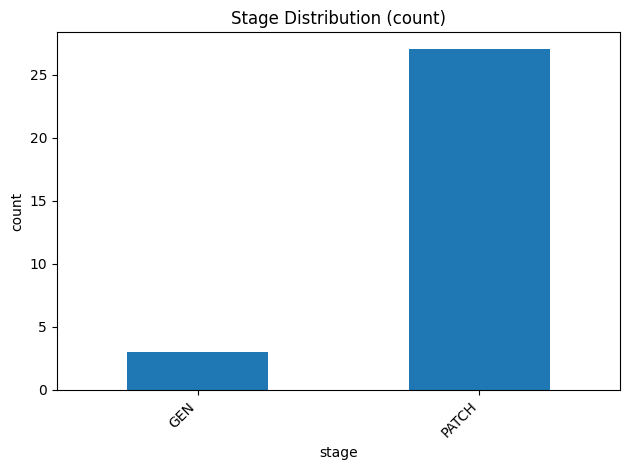

In [5]:
plt.figure()
stage_counts.loc[[s for s in stage_order if s in stage_counts.index] + [s for s in stage_counts.index if s not in stage_order]].plot(kind='bar')
plt.title('Stage Distribution (count)')
plt.xlabel('stage')
plt.ylabel('count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2) Stage × error_type

- PATCH에서 대부분 `PATCH_FAIL`?
- EXEC는 거의 없음?


In [6]:
if 'error_type' not in df.columns:
    raise ValueError('error_type column not found')

pivot_stage_err = pd.crosstab(df['stage'].replace({'': 'MISSING'}), df['error_type'].replace({'': 'MISSING'}))
pivot_stage_err

error_type,GEN_FAIL,PATCH_FAIL
stage,,
GEN,3,0
PATCH,0,27


In [7]:
pivot_stage_err_ratio = pivot_stage_err.div(pivot_stage_err.sum(axis=1).replace(0, np.nan), axis=0)
pivot_stage_err_ratio.round(3)

error_type,GEN_FAIL,PATCH_FAIL
stage,,
GEN,1.0,0.0
PATCH,0.0,1.0


In [8]:
# PATCH stage에서 signature top-k (예: git_apply_failed가 대부분인지)
if 'signature' in df.columns:
    patch_sig = df.loc[df['stage'].eq('PATCH'), 'signature'].replace({'': 'MISSING'})
    patch_sig.value_counts().head(20)

## 3) Stage × 비용

- `gen_elapsed_sec` 평균
- `elapsed_sec` 평균


In [9]:
cost_cols = [c for c in ['gen_elapsed_sec','elapsed_sec'] if c in df.columns]
if not cost_cols:
    raise ValueError('No cost columns found among gen_elapsed_sec / elapsed_sec')

stage_cost = df.groupby('stage')[cost_cols].agg(['count','mean','median','std','min','max']).sort_index()
stage_cost

gen_elapsed_sec                                                   elapsed_sec                                                  
                count      mean    median       std       min       max       count      mean    median       std       min       max
stage                                                                                                                                
GEN                 3  0.017450  0.013208  0.010297  0.009951  0.029189           3  0.017450  0.013208  0.010297  0.009951  0.029189
PATCH              27  2.850036  2.423556  1.156858  1.164956  5.417817          27  0.575925  0.558821  0.074200  0.484404  0.785461

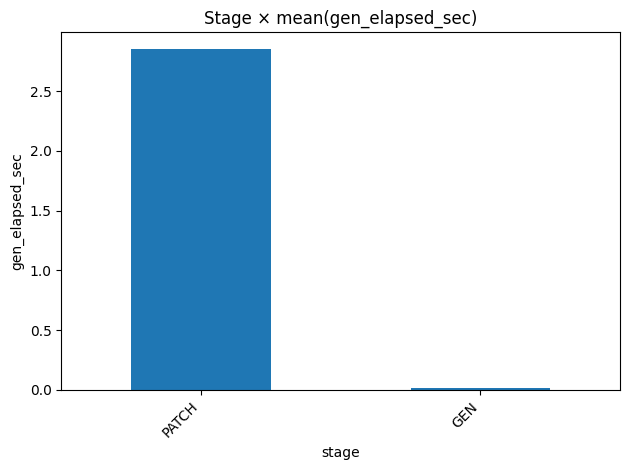

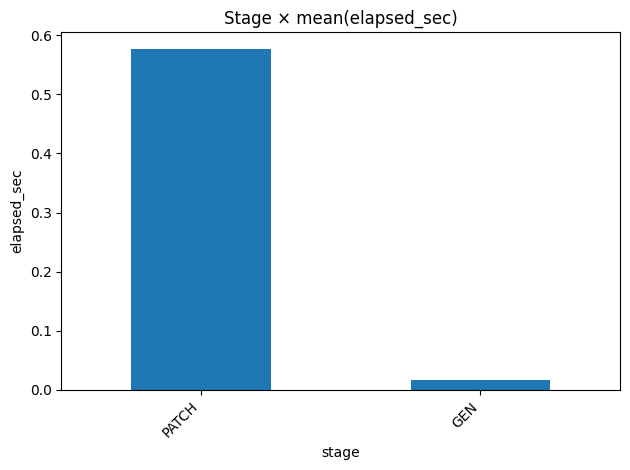

In [10]:
# 분포 시각화 (stage별 평균)
for c in cost_cols:
    plt.figure()
    means = df.groupby('stage')[c].mean().sort_values(ascending=False)
    means.plot(kind='bar')
    plt.title(f'Stage × mean({c})')
    plt.xlabel('stage')
    plt.ylabel(c)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 4) Stage × patch size

- `files_changed`
- `patch_lines_added / removed`


In [11]:
patch_cols = [c for c in ['files_changed','patch_lines_added','patch_lines_removed'] if c in df.columns]
if not patch_cols:
    raise ValueError('No patch size columns found')

stage_patch = df.groupby('stage')[patch_cols].agg(['count','mean','median','std','min','max']).sort_index()
stage_patch

files_changed                                    patch_lines_added                                    patch_lines_removed                             \
              count      mean median       std min max             count      mean median       std min max               count      mean median       std   
stage                                                                                                                                                        
GEN               3  0.000000    0.0  0.000000   0   0                 3  0.000000    0.0  0.000000   0   0                   3  0.000000    0.0  0.000000   
PATCH            27  1.407407    1.0  0.500712   1   2                27  5.185185    4.0  4.851939   1  17                  27  0.962963    1.0  1.159625   

               
      min max  
stage          
GEN     0   0  
PATCH   0   5

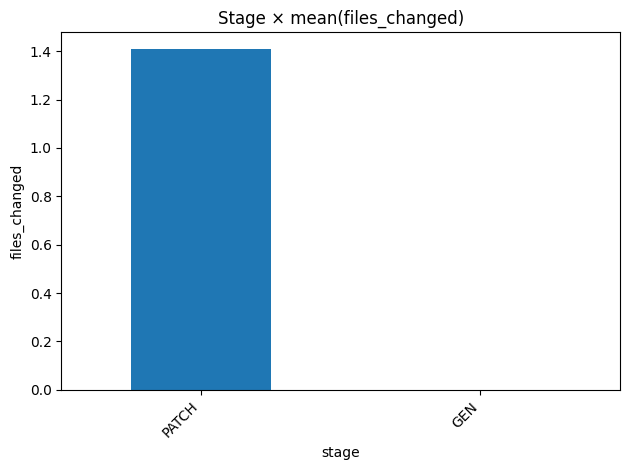

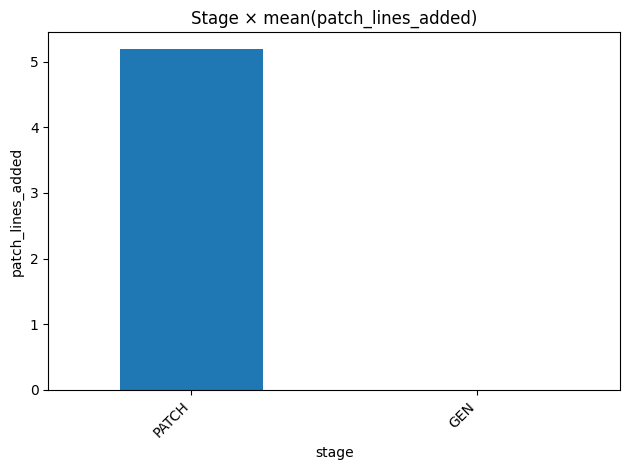

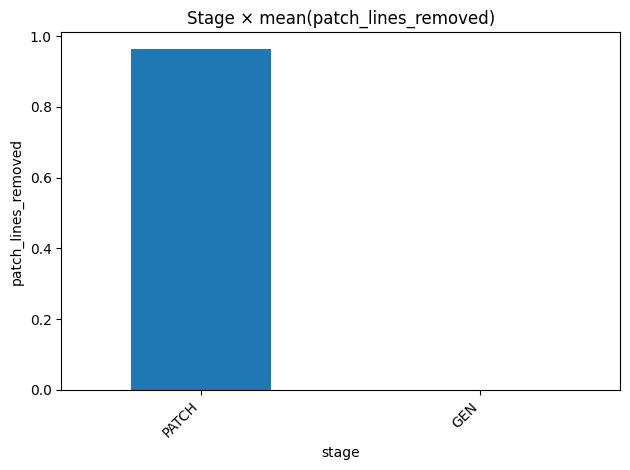

In [12]:
for c in patch_cols:
    plt.figure()
    means = df.groupby('stage')[c].mean().sort_values(ascending=False)
    means.plot(kind='bar')
    plt.title(f'Stage × mean({c})')
    plt.xlabel('stage')
    plt.ylabel(c)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## (옵션) Stage별 핵심 요약 테이블 저장

`runs/.../stage_landscape_summary.csv`로 저장

In [13]:
# out_dir = results_csv.parent
# summary_path = out_dir / 'stage_landscape_summary.csv'

# # 요약: stage별 count + 평균 비용 + 평균 patch size
# summary = pd.DataFrame({'count': df.groupby('stage').size()})
# for c in cost_cols:
#     summary[f'mean_{c}'] = df.groupby('stage')[c].mean()
# for c in patch_cols:
#     summary[f'mean_{c}'] = df.groupby('stage')[c].mean()

# summary = summary.sort_values('count', ascending=False)
# summary.to_csv(summary_path, index=True)
# summary_path, summary